In [27]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

Load the data from the experimental input files for a single participant.

In [28]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_100.xdf')
# for strm in streams:
#     print(f"Found stream {strm['info']['name'][0]} ({strm['info']['type'][0]}) with data shape "
#           f"{np.array(strm['time_series']).shape}")

stream_names = [strm['info']['name'][0] for strm in streams]
stream_types = [strm['info']['type'][0] for strm in streams]

In [29]:
data = {}

for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    data[stream_name] = data_dict



In [46]:
dfs = {}
for stream_name, stream_data in data.items():
    dfs[stream_name] = pd.DataFrame(stream_data)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [64]:
gaze = dfs['GazeStream']
luminance = dfs['LuminanceStream']

pupil_calib_d = gaze.loc[(gaze['MethodID']>98.0) & (gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib_d.reset_index(drop=True, inplace=True)

lum_calib = luminance.loc[(luminance['MethodID']>98.0), ['time', 'Luminance']]
lum_calib.reset_index(drop=True, inplace=True)

gaze_luminance_time = np.intersect1d(pupil_calib_d['time'], lum_calib['time'])

pupil_calib_d = pupil_calib_d[pupil_calib_d['time'].isin(gaze_luminance_time)]
lum_calib = lum_calib[lum_calib['time'].isin(gaze_luminance_time)]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib.reset_index(drop=True, inplace=True)

pupil_calib_d.info()
lum_calib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                3443 non-null   float64
 1   LeftPupilDiameter   3443 non-null   float32
 2   RightPupilDiameter  3443 non-null   float32
dtypes: float32(2), float64(1)
memory usage: 53.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       3443 non-null   float64
 1   Luminance  3443 non-null   float32
dtypes: float32(1), float64(1)
memory usage: 40.5 KB


In [69]:
pupil_calib_d.describe()
pupil_d_l_norm = (pupil_calib_d['LeftPupilDiameter'] - pupil_calib_d['LeftPupilDiameter'].min())/pupil_calib_d['LeftPupilDiameter'].max()
pupil_d_r_norm = (pupil_calib_d['RightPupilDiameter'] - pupil_calib_d['RightPupilDiameter'].min())/pupil_calib_d['RightPupilDiameter'].max()



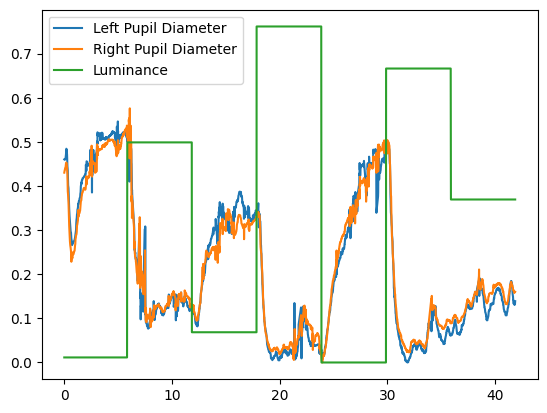

In [71]:
#plot pupil d and luminance
fig, ax = plt.subplots()
ax.plot(pupil_calib_d['time']-pupil_calib_d['time'][0], pupil_d_l_norm, label='Left Pupil Diameter')
ax.plot(pupil_calib_d['time']-pupil_calib_d['time'][0], pupil_d_r_norm, label='Right Pupil Diameter')
ax.plot(lum_calib['time']-lum_calib['time'][0], lum_calib['Luminance'], label='Luminance')
ax.legend()
plt.show()

In [76]:
#The predicted pupil dilation, d(Y), caused by the luminance Y was computed using the following equation:
#𝑑(𝑌) = 𝑎 · 𝑒^(−𝑏·𝑌) + c
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c


In [91]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]

popt_l, pcov_l = curve_fit(func, lum_calib['Luminance'], pupil_calib_d['LeftPupilDiameter'], bounds=([1, 4, 0], [4, 8, 8]))

luminance_pupil_diameter = pupil_calib_d.join(lum_calib['Luminance'], how='inner', on='time')
sorted_luminance = np.sort(luminance_pupil_diameter['Luminance'])
#popt_r, pcov_r = curve_fit(func, lum_calib['Luminance'], pupil_calib_d['RightPupilDiameter'], bounds=([1, 4, 0], [4, 8, 8]))

C:\Users\court\AppData\Local\Temp\ipykernel_12004\2745851080.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  luminance_pupil_diameter = pupil_calib_d.join(lum_calib['Luminance'], how='inner', on='time')


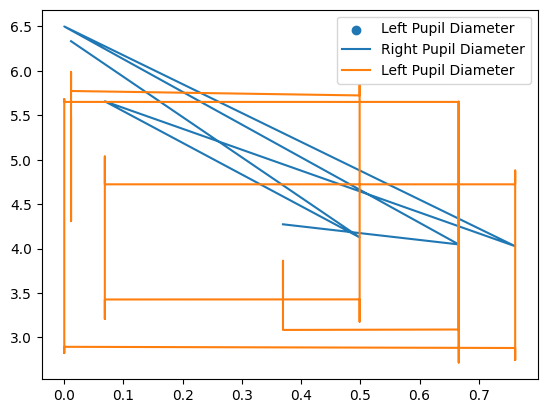

In [101]:
#plot popt_l and sorted_luminance[luminance] and pupil_diameter
fig, ax = plt.subplots()
ax.scatter(sorted_luminance, func(sorted_luminance, *popt_l), label='Left Pupil Diameter')
#ax.plot(lum_calib['Luminance'], func(lum_calib['Luminance'], *popt_r), label='Right Pupil Diameter')
ax.plot(lum_calib['Luminance'], pupil_calib_d['LeftPupilDiameter'], label='Left Pupil Diameter')
#ax.scatter(lum_calib['Luminance'], pupil_calib_d['RightPupilDiameter'], label='Right Pupil Diameter')
ax.legend()
plt.show()

